# Sentiment Analysis (Transfer Learning)

## Preparación de ambiente

### Carga de módulos

In [ ]:
!pip install pandarallel stylecloud

In [ ]:
# Misc
from pandarallel import pandarallel
from warnings import filterwarnings

# Data Wrangling
import numpy as np
import pandas as pd

# Data exploration
from PIL import Image
import cufflinks as cf
from stylecloud import gen_stylecloud

# Preprocessing
import re
import nltk
import spacy
import unicodedata
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.utils import to_categorical

# Modeling
import keras
import tensorflow as tf
import tensorflow_hub as hub
import keras.layers as layers
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from sklearn.model_selection import train_test_split

# Environment setup
cf.go_offline()
filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("stopwords")
pandarallel.initialize(progress_bar=True)

## Conexión con Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Funciones auxiliares

In [ ]:
def clean_text(text, pattern="[^a-zA-Z0-9 ]"):
    """Cleans the text to facilitate its analysis, it changes accented letters to its quivalent without accents, removes also special characters

    Parameters
    ----------
    text : string
        String containing text
    pattern : str, optional
        Regular expession for keeping in the string, by default ``[^a-zA-Z0-9 ]``

    Returns
    -------
    cleaned_text : string
        Cleaned string

    Example
    -------
    >>> clean_text('¡Feliz año nuevo, México!')
    >>> u'feliz ano nuevo mexico'
    """
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, "", cleaned_text.decode("utf-8"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().split())
    return cleaned_text

In [ ]:
def get_wordcloud(text, icon="fas fa-comments", background_color=None, output_name="./wordcloud.png"):
    # https://fontawesome.com/icons/alicorn?s=solid
    gen_stylecloud(text=text, icon_name=icon, background_color=background_color, output_name=output_name)
    return Image.open(output_name) 

In [ ]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))["default"]

## Data Wrangling

### Lectura de datos

In [ ]:
df = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/FES Acatlán/Cursos/ANIEI/NLP/Datos/training.1600000.processed.noemoticon.csv',
                 names=['target', 'id', 'date', 'flag','user','text'],
                 encoding = "ISO-8859-1")

## Análisis exploratorio

### Diccionario de datos

El dataset contiene 1,600,000 tweets (sin emojis) que han sido etiquetados de acuerdo con la polaridad. El diccionario de datos es el siguiente:
 * target: Polaridad del tweet (0 = negativo, 2 = neutral, 4 = positivo)
 * ids: El ID del tweet (Ej.: 2087)
 * date: La fecha del tweet (Ej.: Sat May 16 23:58:44 UTC 2009)
 * flag: La consulta (lyx). Si no hay consulta, entonces este valor es NO_QUERY.
 * user: El usuario que emitió el tweet (Ej.: robotickilldozr)
 * text: El texto del tweet (Ej.: Lyx is cool)

In [ ]:
df.info(memory_usage="deep")

In [ ]:
df.head()

### Distribución de la variable objetivo

In [11]:
df["target"].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [12]:
df["target"] = df["target"].map({0: "NEG", 4: "POS"})

### Nubes de palabras

#### Negativo

In [14]:
neg_text = " ".join(df.loc[df["target"]=="NEG", "text"].sample(frac=0.1))

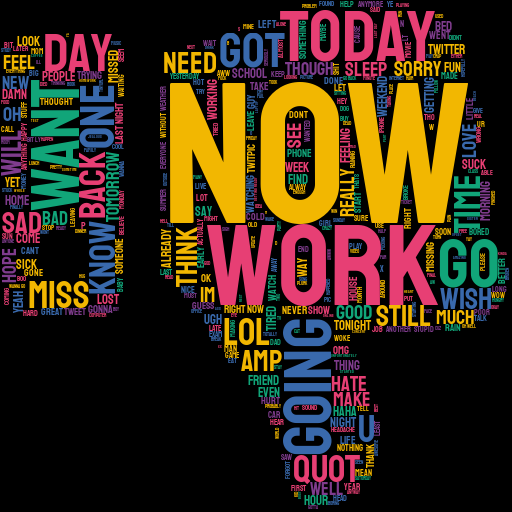

In [15]:
get_wordcloud(neg_text, icon="fas fa-thumbs-down", background_color=None, output_name="./wordcloud_neg.png")

#### Positivo

In [16]:
pos_text = " ".join(df.loc[df["target"]=="POS", "text"].sample(frac=0.1))

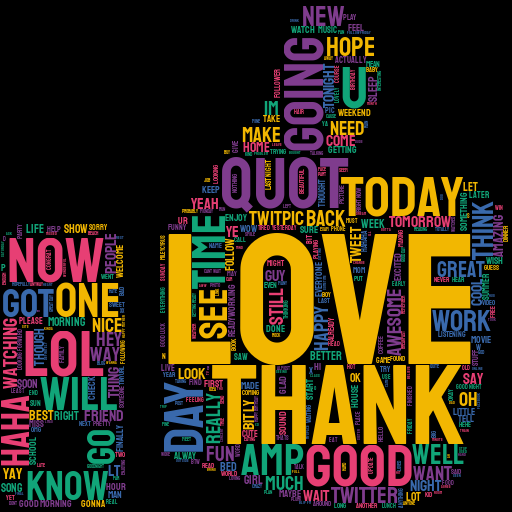

In [17]:
get_wordcloud(pos_text, icon="fas fa-thumbs-up", background_color=None, output_name="./wordcloud_pos.png")

### Limpieza de datos

#### Remoción de URLs

In [18]:
df

,target,id,date,flag,user,text
0,NEG,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEG,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEG,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEG,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEG,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,POS,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,POS,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,POS,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,POS,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [19]:
url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"


In [20]:
df["text"] = df["text"].map(lambda tweet: re.sub(url_pattern, '', tweet))

In [21]:
df

,target,id,date,flag,user,text
0,NEG,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot - Awww, that's a bummer. You sho..."
1,NEG,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEG,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEG,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEG,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,POS,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,POS,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,POS,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,POS,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


#### Remoción de menciones

In [22]:
user_pattern = '@[^\s]+'

In [23]:
df["text"] = df["text"].map(lambda tweet: re.sub(user_pattern, '', tweet))

In [24]:
df

,target,id,date,flag,user,text
0,NEG,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"- Awww, that's a bummer. You shoulda got Da..."
1,NEG,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEG,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,I dived many times for the ball. Managed to s...
3,NEG,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEG,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"no, it's not behaving at all. i'm mad. why am..."
...,...,...,...,...,...,...
1599995,POS,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,POS,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,POS,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,POS,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


#### Conversión de emojis

In [25]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [27]:
for emoji in emojis.keys():
    df["text"] = df["text"].str.replace(emoji, emojis[emoji], regex=False)

#### Normalización de texto

In [28]:
df["text"] = df["text"].map(clean_text)

In [29]:
df

,target,id,date,flag,user,text
0,NEG,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david carr...
1,NEG,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,NEG,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...
3,NEG,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEG,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...
...,...,...,...,...,...,...
1599995,POS,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up having no school is the best feel...
1599996,POS,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom very cool to hear old walt interviews a
1599997,POS,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover ask me fo...
1599998,POS,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday to my boo of alll time tup...


#### Remoción de _stopwords_

In [30]:
words_to_remove = ['for','by','with','against','shan','dont', 'don', 'didn', 'ain', 'couldn',
                   'couldnt', 'didnt','arent','havent','werent', 'until', 'aint', 'but', 
                   'off','out']

In [31]:
ls_stopwords = [word for word in map(clean_text, stopwords.words('english')) if word not in words_to_remove]

In [32]:
df["text"] = df["text"].str.split().parallel_map(lambda words: [word for word in words if word not in ls_stopwords]).str.join(" ")

#### Lemmatizado

In [33]:
nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])

In [34]:
df["text"] = df["text"].parallel_map(lambda sentence: [token.lemma_ for token in nlp(sentence)]).str.join(" ")

KeyboardInterrupt: ignored

### Nubes de palabras (texto limpio)

#### Negativo

In [ ]:
neg_text = " ".join(df.loc[df["target"]=="NEG", "text"].sample(frac=0.1))

In [ ]:
get_wordcloud(neg_text, icon="fas fa-thumbs-down", background_color=None, output_name="./wordcloud_neg_clean.png")

#### Positivo

In [ ]:
pos_text = " ".join(df.loc[df["target"]=="POS", "text"].sample(frac=0.1))

In [ ]:
get_wordcloud(pos_text, icon="fas fa-thumbs-up", background_color=None, output_name="./wordcloud_pos_clean.png")

### Separación de sets

#### Preparación de conjuntos

In [ ]:
X = df["text"]
y = df["target"]

In [ ]:
le = LabelEncoder()

In [ ]:
y = le.fit_transform(y)

In [ ]:
y = to_categorical(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Entrenamiento

### Carga de modelo preentrenado

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

embed_size = embed.variables[-1].shape[-1]
print("Embedding size: ", embed_size)

In [ ]:
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = ("Universal Sentence Encoder embeddings also support short paragraphs. "
             "There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

In [ ]:
for element in messages:
    print(element, embed([element])[0][:10])

### Construcción del modelo

#### Capa de entrada

In [ ]:
input_text = layers.Input(shape=(1,), dtype="string")

#### Capa de embedding

In [ ]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))["default"]

In [ ]:
embed(X)

In [ ]:
embedding = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text)

#### Capas ocultas

In [ ]:
x = layers.Dense(256, activation='relu')(embedding)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.125)(x)

#### Capa de salida

In [ ]:
x = layers.Dense(len(le.classes_), activation='sigmoid')(x)

#### Configuración del modelo

In [ ]:
model_sa = Model(inputs=[input_text], outputs=x)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model_sa.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_sa.summary()

#### Callbacks

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.0001)

In [ ]:
checkpoint = ModelCheckpoint('models/sentiment/model_{val_accuracy:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_accuracy')

### Entrenamiento

In [ ]:
history = model_sa.fit(X_train, y_train, epochs=10, batch_size=1024, callbacks=[early_stopping, checkpoint], validation_data=(X_test, y_test))

In [ ]:
loss, acc = model.evaluate(X_test, y_test)

In [ ]:
results = pd.DataFrame(data = zip(history.history["loss"], history.history["val_loss"], history.history["accuracy"], history.history["val_accuracy"]), columns=["loss", "val_loss", "accuracy", "val_accuracy"])

In [ ]:
results.iplot()

In [ ]:
df["y_hat"] = le.inverse_transform(np.arg_max(model_sa.predict(X), axis=1))